In [ ]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
!pip install -q segmentation-models-pytorch albumentations torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 38.9 MB/s eta 0:00:00


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import albumentations as album
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from pathlib import Path
import torch.backends.cudnn as cudnn
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.metrics import iou_score
from segmentation_models_pytorch import utils as smp_utils
from segmentation_models_pytorch.utils import metrics as smp_metrics

In [4]:
# Enable faster training with cuDNN optimization
cudnn.benchmark = True

# Set device: 'cuda' if available, else 'cpu'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read the data

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/deepglobe-road-extraction-dataset")

print("Path to dataset files:", path)

100%|██████████| 3.79G/3.79G [00:54<00:00, 74.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/deepglobe-road-extraction-dataset/versions/2


In [6]:
# Set dataset directory
DATA_DIR = Path('/root/.cache/kagglehub/datasets/balraj98/deepglobe-road-extraction-dataset/versions/2')

# Load metadata
metadata_df = pd.read_csv(DATA_DIR / 'metadata.csv')
metadata_df = metadata_df[metadata_df['split'] == 'train'][['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda x: DATA_DIR / x)
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda x: DATA_DIR / x)

# Shuffle data and split into train/valid sets
metadata_df = metadata_df.sample(frac=1, random_state=42).reset_index(drop=True)
valid_df = metadata_df.sample(frac=0.15, random_state=42)
train_df = metadata_df.drop(valid_df.index)

In [7]:
# Load class dictionary
class_dict = pd.read_csv(DATA_DIR / 'class_dict.csv')
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

# Select classes
select_classes = ['background', 'road']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

In [8]:
# Function to visualize images
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); plt.yticks([])
        plt.title(name.replace('_', ' ').title(), fontsize=16)
        plt.imshow(image)
    plt.show()

In [9]:
# One-hot encoding function
def one_hot_encode(label, label_values):
    """Returns binary mask for road class (shape: H,W,1)"""
    road_rgb = label_values[1]  # Get road RGB value
    road_mask = (label == road_rgb).all(axis=-1)  # Binary road mask
    return np.expand_dims(road_mask, axis=-1).astype(np.float32)  # Add channel dim

# Reverse one-hot encoding
def reverse_one_hot(one_hot_mask):
    """Converts (1,H,W) output to (H,W) binary mask"""
    if isinstance(one_hot_mask, torch.Tensor):
        one_hot_mask = one_hot_mask.cpu().numpy()
    return (one_hot_mask.squeeze() > 0.5).astype(np.uint8)  # Threshold at 0.5

def colour_code_segmentation(image, label_values):
    """Color code binary mask"""
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    return np.where(image[..., None], label_values[1], label_values[0])

# Pad and resize image

In [10]:
# Optimized Dataset Class
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset

# Change max_size here to resize the image
# pad_image function ensure that all images feed to the model have the same size
def pad_image(image, max_stride=32, max_size=512):
    h, w = image.shape[:2]

    # Align max_size to stride if needed
    if max_size % max_stride != 0:
        max_size = ((max_size + max_stride - 1) // max_stride) * max_stride

    # Resize if larger than max_size
    if h > max_size or w > max_size:
        scale = min(max_size / h, max_size / w)
        new_w, new_h = int(w * scale), int(h * scale)
        image = cv2.resize(image, (new_w, new_h))
        h, w = image.shape[:2]

    # Pad to exactly max_size (which is stride aligned)
    pad_bottom = max_size - h
    pad_right = max_size - w

    return cv2.copyMakeBorder(image, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=0)

class RoadsDataset(Dataset):
    def __init__(self, df, class_rgb_values, augmentation=None, preprocessing=None):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # Load image and mask
        image = cv2.imread(str(self.image_paths[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.mask_paths[i]))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Pad images
        image = pad_image(image)
        mask = pad_image(mask)

        # Create binary road mask (H,W,1)
        mask = one_hot_encode(mask, self.class_rgb_values)

        # Apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # Convert to tensor (C,H,W)
        image = torch.from_numpy(image).float().permute(2, 0, 1)
        mask = torch.from_numpy(mask).float().permute(2, 0, 1)

        return image, mask

    def __len__(self):
        return len(self.image_paths)

# Data Augmentation

In [11]:
# Data augmentation
def get_training_augmentation():
    return album.Compose([
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
        album.RandomBrightnessContrast(p=0.2),
        album.Rotate(limit=30, p=0.5),
        album.GaussNoise(std_range = (0.1, 0.2), p=0.2)
    ])

# Convert image to tensor
def to_tensor(x, **kwargs):
    return x.astype('float32')

# Preprocessing function
def get_preprocessing(preprocessing_fn=None):
    transforms = []
    if preprocessing_fn:
        transforms.append(album.Lambda(image=preprocessing_fn))
    transforms.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(transforms)

Fixed Sample image shape: torch.Size([3, 512, 512])
Fixed Sample mask shape: torch.Size([1, 512, 512])


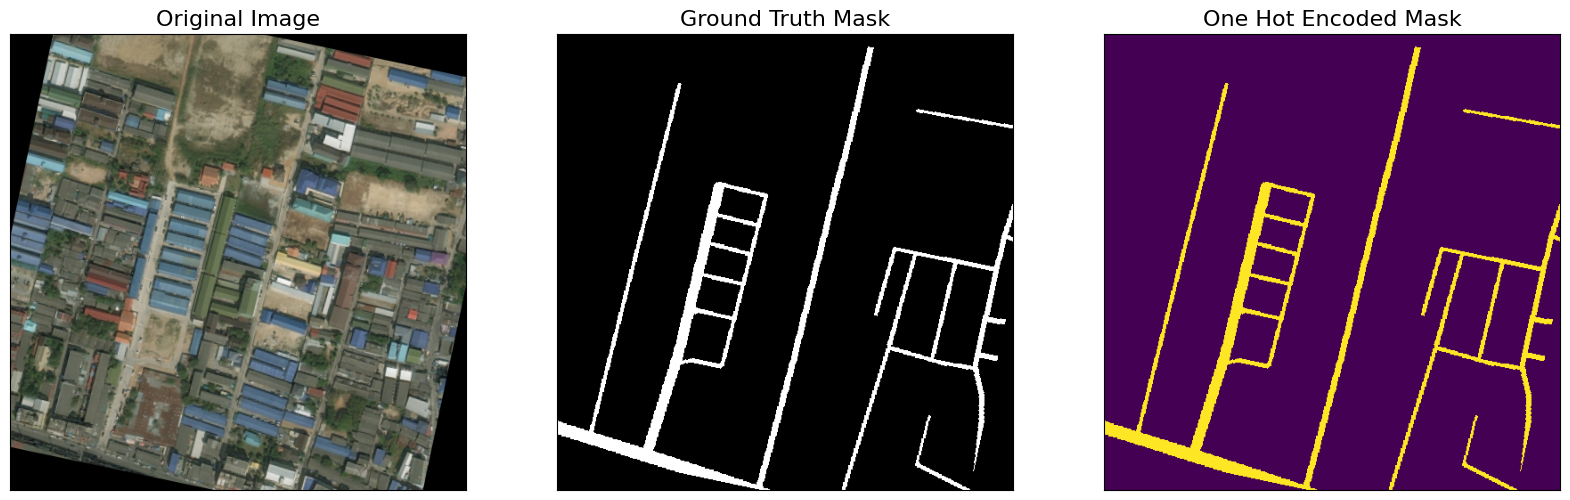

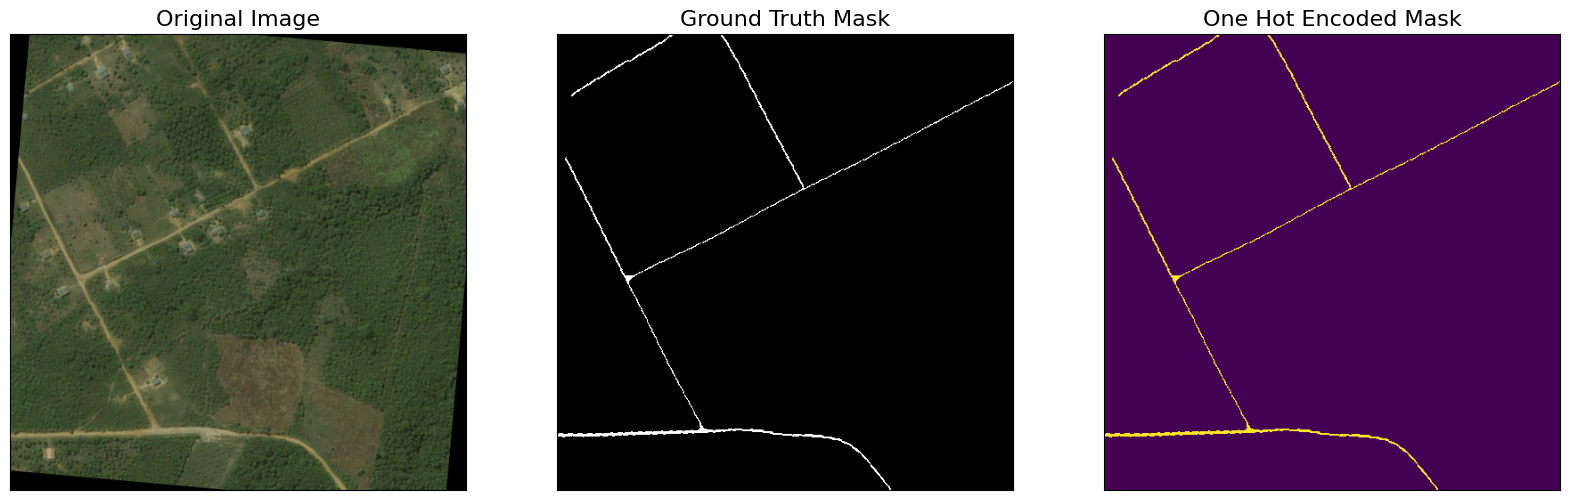

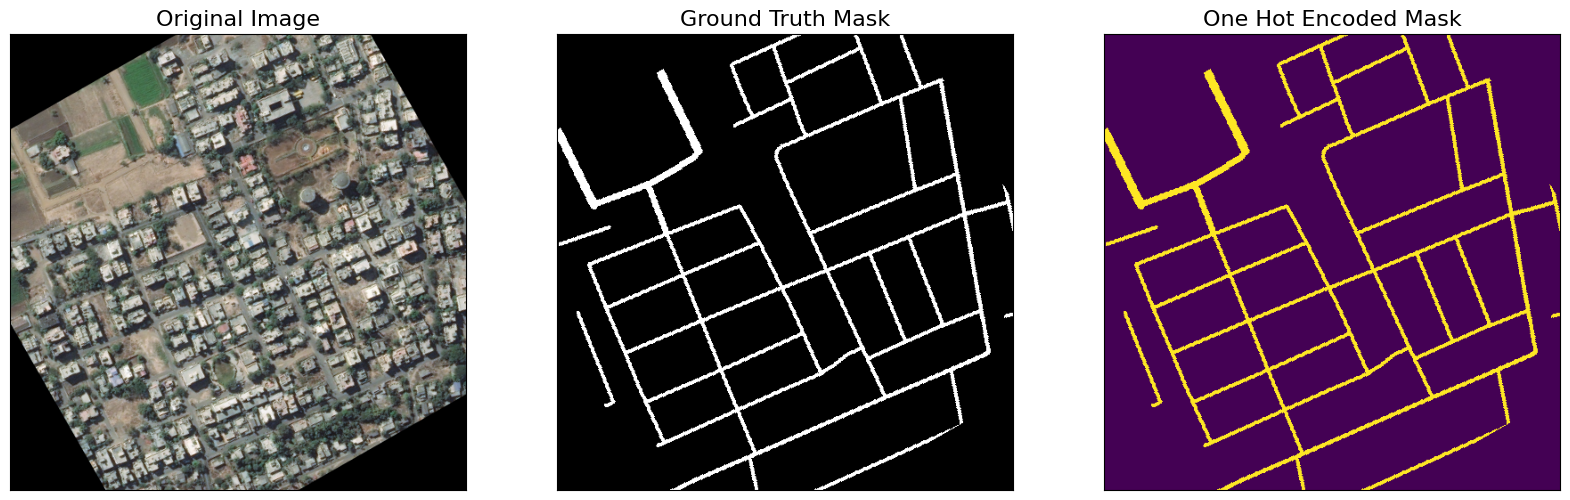

In [12]:
# Visualize Sample Image and Mask
dataset = RoadsDataset(train_df, class_rgb_values=select_class_rgb_values, augmentation = get_training_augmentation())

sample_img, sample_mask = dataset[0]
print(f"Fixed Sample image shape: {sample_img.shape}")
print(f"Fixed Sample mask shape: {sample_mask.shape}")

for i in range(3):
    random_idx = random.randint(0, len(dataset)-1)

    # Get sample
    image_tensor, mask = dataset[random_idx]

    # Convert image back to HWC numpy array
    image_np = image_tensor.permute(1, 2, 0).numpy()  # CHW -> HWC

    # Since your dataset has no normalization, values should be 0-255, but are still float32
    if image_np.dtype == np.float32:
        image_np = image_np.astype(np.uint8)  # Convert to uint8 (0-255)

    # Process mask
    mask_indices = reverse_one_hot(mask)
    colored_mask = colour_code_segmentation(mask_indices, select_class_rgb_values)

    # Visualize
    visualize(
        original_image=image_np,
        ground_truth_mask=colored_mask,
        one_hot_encoded_mask=mask_indices
    )

# Define model, encoder, weight, preprocessing function

In [13]:
import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=1,
    activation=ACTIVATION
).to(DEVICE)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [14]:
from segmentation_models_pytorch.encoders import get_preprocessing_fn, get_preprocessing_params

preprocessing_fn = get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
preprocessing_params = get_preprocessing_params(ENCODER, ENCODER_WEIGHTS)
print("Mean:", preprocessing_params['mean'])
print("Std:", preprocessing_params['std'])


Mean: [0.485, 0.456, 0.406]
Std: [0.229, 0.224, 0.225]


# Data preprocessing

In [15]:
# Create datasets and dataloaders
train_dataset = RoadsDataset(train_df, select_class_rgb_values, augmentation = get_training_augmentation(), preprocessing = get_preprocessing(preprocessing_fn))
valid_dataset = RoadsDataset(valid_df, select_class_rgb_values, augmentation = None, preprocessing = get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [16]:
sample_img, sample_mask = train_dataset[0]
print(f"Fixed train image shape: {sample_img.shape}")
print(f"Fixed train mask shape: {sample_mask.shape}")

Fixed train image shape: torch.Size([3, 512, 512])
Fixed train mask shape: torch.Size([1, 512, 512])


In [17]:
sample_img, sample_mask = valid_dataset[0]
print(f"Fixed valid image shape: {sample_img.shape}")
print(f"Fixed valid mask shape: {sample_mask.shape}")

Fixed valid image shape: torch.Size([3, 512, 512])
Fixed valid mask shape: torch.Size([1, 512, 512])


# Training loss, metrics and learning rate scheduler

In [18]:
# Define loss function, optimizer, and metrics
loss = smp.utils.losses.DiceLoss() + smp.utils.losses.BCELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5)]

# Change learning rate here
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='max',
                                                       factor=0.6,
                                                       patience=2,
                                                       min_lr=1e-6,
                                                       threshold=0.001,
                                                       cooldown=1)

patience = 6
patience_counter = 0

In [19]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [21]:
dummy_input = torch.randn(4, 3, 512, 512).to(DEVICE)
dummy_output = model(dummy_input)
print(f"Dummy output shape: {dummy_output.shape}")

Dummy output shape: torch.Size([4, 1, 512, 512])


In [ ]:
# !pip install wandb -q

In [ ]:
# import wandb
# wandb.login(key="b94608572f4b7a61fd3bcc5958610e84e38e42e1")

# wandb.init(project="road_segmentation", name="Segnet_vgg16_01")

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# Training loop

In [24]:
from segmentation_models_pytorch.utils.metrics import Precision, Recall

# -------------------------------------------------------
# TRAINING SETUP
# -------------------------------------------------------

EPOCHS = 20
best_iou_score = 0.0

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=[
        smp.utils.metrics.IoU(threshold=0.5),
        smp.utils.metrics.Fscore(threshold=0.5),    # keep FScore
        Precision(threshold=0.5),
        Recall(threshold=0.5)
    ],
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=[
        smp.utils.metrics.IoU(threshold=0.5),
        smp.utils.metrics.Fscore(threshold=0.5),
        Precision(threshold=0.5),
        Recall(threshold=0.5)
    ],
    device=DEVICE,
    verbose=True
)

# -------------------------------------------------------
# METRIC STORAGE LISTS
# -------------------------------------------------------
epoch_list = []

train_loss_list = []
valid_loss_list = []

train_iou_list = []
valid_iou_list = []

train_fscore_list = []
valid_fscore_list = []

train_precision_list = []
valid_precision_list = []

train_recall_list = []
valid_recall_list = []


# -------------------------------------------------------
# TRAINING LOOP
# -------------------------------------------------------
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    start_time = time.time()

    # Gentle LR phase
    if epoch == EPOCHS - 10:
        scheduler.factor = 0.8
        print("\nEntering final phase: gentler LR reductions")

    # Run train + valid
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # Store epoch no.
    epoch_list.append(epoch + 1)

    # Loss
    train_loss_list.append(train_logs['dice_loss + bce_loss'])
    valid_loss_list.append(valid_logs['dice_loss + bce_loss'])

    # IoU
    train_iou_list.append(train_logs['iou_score'])
    valid_iou_list.append(valid_logs['iou_score'])

    # FScore (F1)
    train_fscore_list.append(train_logs['fscore'])
    valid_fscore_list.append(valid_logs['fscore'])

    # Precision
    train_precision_list.append(train_logs['precision'])
    valid_precision_list.append(valid_logs['precision'])

    # Recall
    train_recall_list.append(train_logs['recall'])
    valid_recall_list.append(valid_logs['recall'])

    # LR scheduler
    scheduler.step(valid_logs['iou_score'])

    # Checkpointing
    current_iou = valid_logs['iou_score']
    if current_iou > best_iou_score:
        best_iou_score = current_iou
        torch.save(model.state_dict(), "best_model.pth")
        patience_counter = 0
        print(f"New best IoU: {best_iou_score:.4f}")
    else:
        patience_counter += 1
        if (best_iou_score - current_iou) > 0.002:
            print(f"⏳ Patience: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("🛑 Early stopping triggered")
                break

    # Cleanup
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Epoch completed in {time.time() - start_time:.2f} seconds")


Epoch 1/20
valid: 100%|██████████| 234/234 [00:39<00:00,  5.96it/s, dice_loss + bce_loss - 0.428, iou_score - 0.5224, fscore - 0.6826, precision - 0.6635, recall - 0.7142]
New best IoU: 0.5224
Epoch completed in 511.42 seconds

Epoch 2/20
valid: 100%|██████████| 234/234 [00:38<00:00,  6.01it/s, dice_loss + bce_loss - 0.4259, iou_score - 0.5164, fscore - 0.6769, precision - 0.7266, recall - 0.6455]
⏳ Patience: 1/6
Epoch completed in 514.89 seconds

Epoch 3/20
valid: 100%|██████████| 234/234 [00:38<00:00,  6.08it/s, dice_loss + bce_loss - 0.413, iou_score - 0.5279, fscore - 0.6868, precision - 0.7172, recall - 0.6704]
New best IoU: 0.5279
Epoch completed in 514.75 seconds

Epoch 4/20
valid: 100%|██████████| 234/234 [00:39<00:00,  5.97it/s, dice_loss + bce_loss - 0.4185, iou_score - 0.5227, fscore - 0.6827, precision - 0.705, recall - 0.6748]
⏳ Patience: 1/6
Epoch completed in 514.88 seconds

Epoch 5/20
valid: 100%|██████████| 234/234 [00:39<00:00,  5.98it/s, dice_loss + bce_loss - 0.403

In [25]:
from google.colab import files

files.download('/content/best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluation

In [26]:
# Model evaluation
best_model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=1,
    activation=ACTIVATION
).to(DEVICE)

best_model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
best_model.to(DEVICE)
best_model.eval()

with torch.no_grad():
    test_epoch = smp.utils.train.ValidEpoch(
        best_model, loss=loss, metrics=metrics, device=DEVICE, verbose=True
    )
    valid_logs = test_epoch.run(valid_loader)

# Print evaluation results
print("\nEvaluation Results:")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['fscore']:.4f}")

valid: 100%|██████████| 234/234 [00:38<00:00,  6.09it/s, dice_loss + bce_loss - 0.3669, iou_score - 0.5723, fscore - 0.725]

Evaluation Results:
Mean IoU Score: 0.5723
Mean Dice Loss: 0.7250


# Visualize prediction on satelite images (w/ no ground truth)

In [27]:
def denormalize_image(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    De-normalizes a tensor that was normalized using ImageNet statistics.
    Args:
        image_tensor (torch.Tensor): Tensor of shape (C, H, W), values in [0, 1] normalized.
        mean (list): Channel-wise mean used during normalization.
        std (list): Channel-wise std used during normalization.
    Returns:
        np.ndarray: De-normalized image in uint8 format, shape (H, W, C)
    """
    image = image_tensor.clone().cpu().numpy()
    for c in range(3):  # Assuming 3 channels (RGB)
        image[c] = image[c] * std[c] + mean[c]
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image = (image * 255).clip(0, 255).astype(np.uint8)
    return image

Image # 0


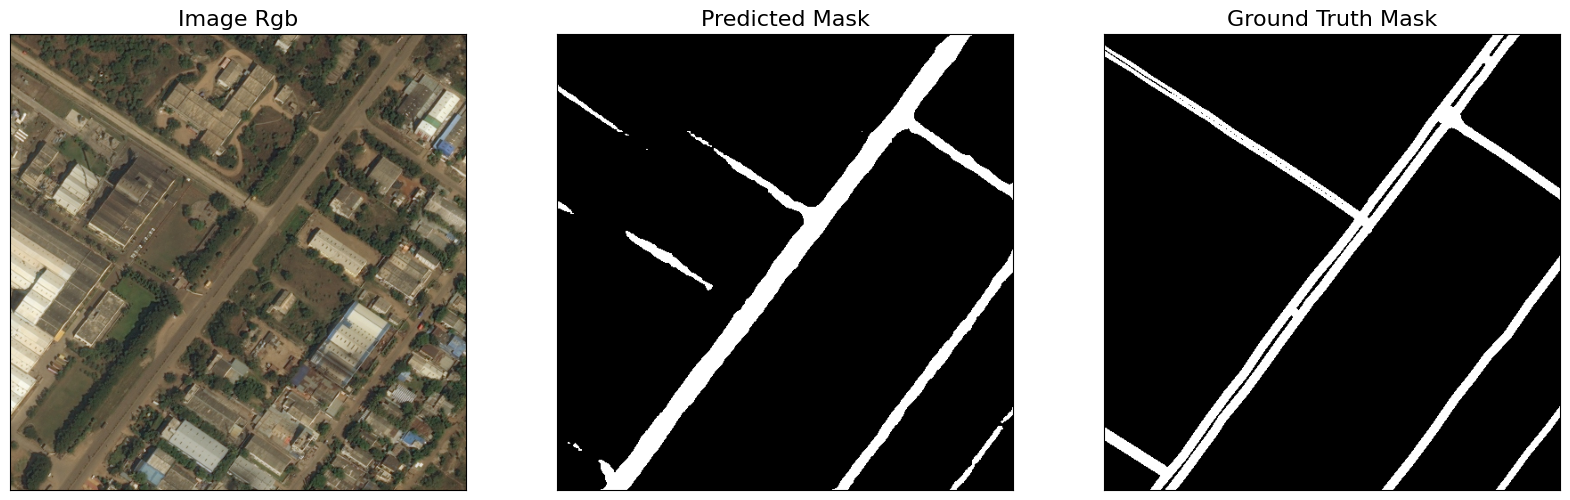

Image # 1


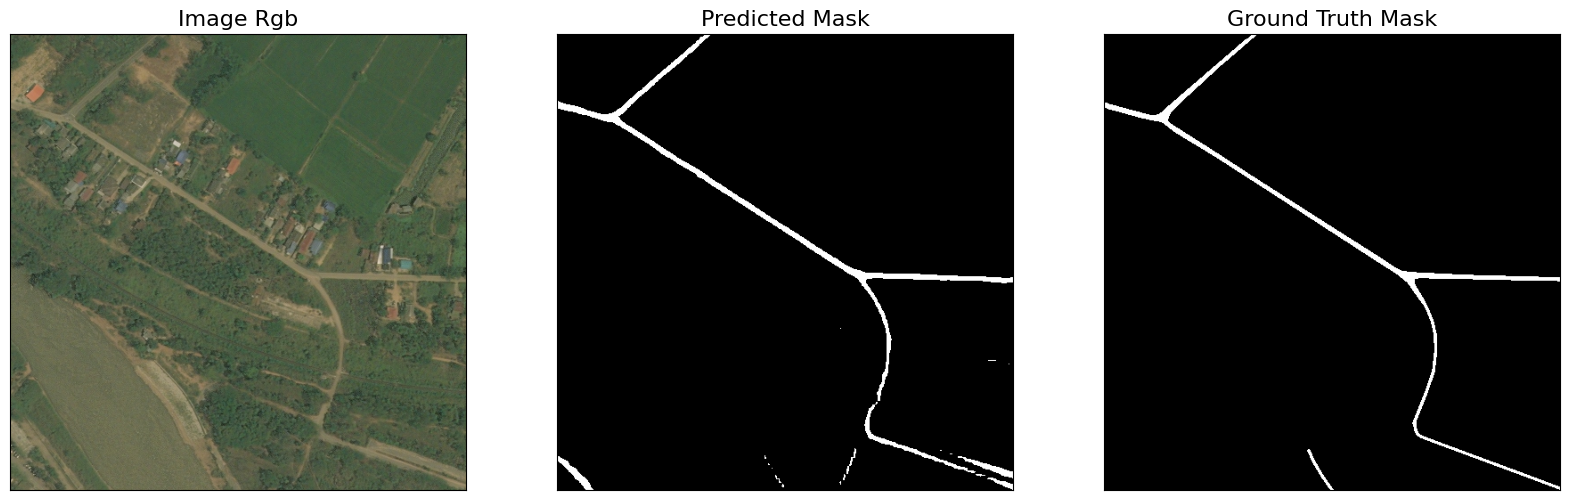

Image # 2


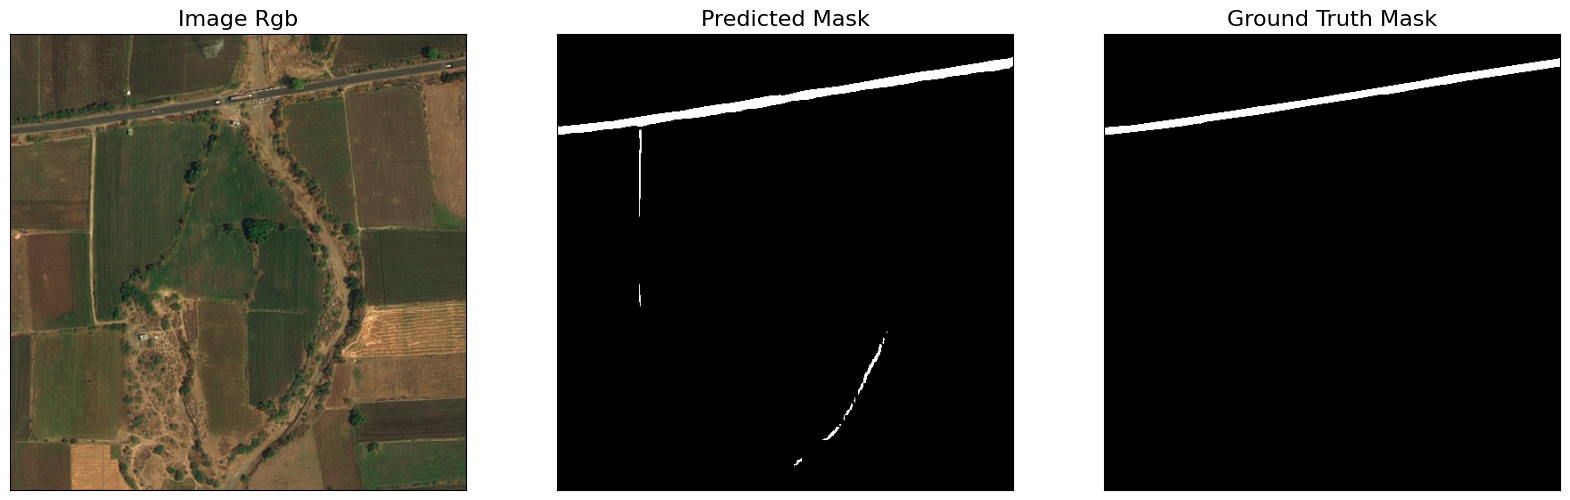

Image # 3


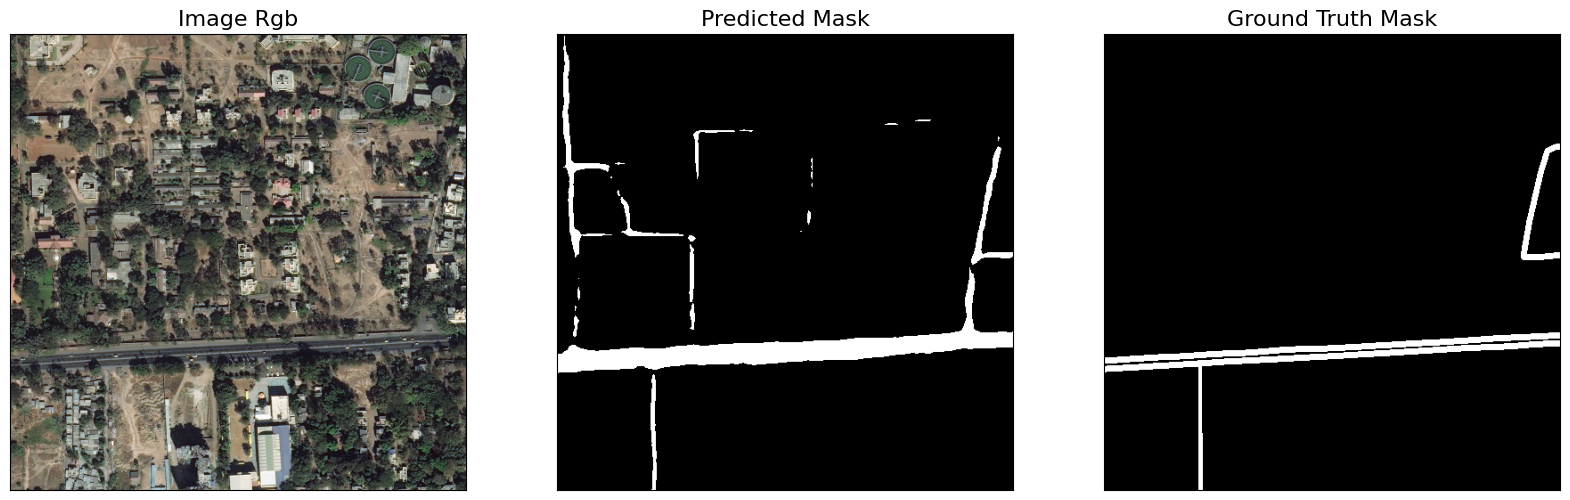

Image # 4


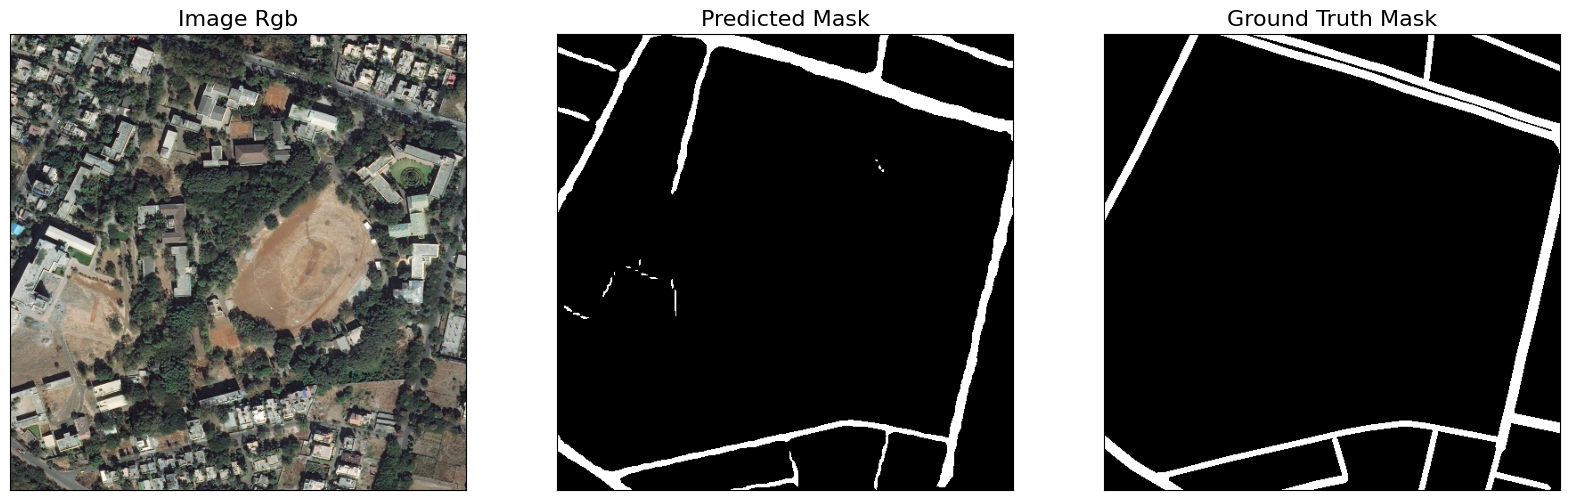

In [28]:
def visualize_predictions(
    model,
    dataset,
    start_idx=0,
    end_idx=5,
    device=DEVICE,
    threshold=0.5,  # Keep threshold to match training metrics
):
    """
    Optimized visualization for road segmentation with threshold matching training metrics.

    Args:
        model: Trained road segmentation model (output shape: (1,H,W))
        dataset: Test dataset
        start_idx/end_idx: Range to visualize
        device: Target device
        threshold: 0.5 to match IoU/Fscore metrics (critical for consistency)
    """
    model.eval()

    # Color codes - adjust based on your label convention
    BACKGROUND_COLOR = [0, 0, 0]    # Black
    ROAD_COLOR = [255, 255, 255]     # White

    with torch.no_grad():
        for i in range(start_idx, end_idx):
            print("Image # " + str(i))

            image, mask = dataset[i]

            image_tensor = image.unsqueeze(0).to(DEVICE)

            preds = model(image_tensor).squeeze(1) # Remove channel dim for (B,H,W)

            # Vectorized processing
            binary_masks = (preds > threshold).cpu().numpy()

            # Process mask
            mask_indices = reverse_one_hot(mask)
            ground_truth = colour_code_segmentation(mask_indices, select_class_rgb_values)

            for i, mask in enumerate(binary_masks):
                # Efficient color mapping
                colored_mask = np.empty((*mask.shape, 3), dtype=np.uint8)
                colored_mask[mask == 1] = ROAD_COLOR
                colored_mask[mask == 0] = BACKGROUND_COLOR

                visualize(
                    image_rgb=denormalize_image(image),
                    predicted_mask=colored_mask,
                    ground_truth_mask=ground_truth,
                )

visualize_predictions(best_model, valid_dataset)

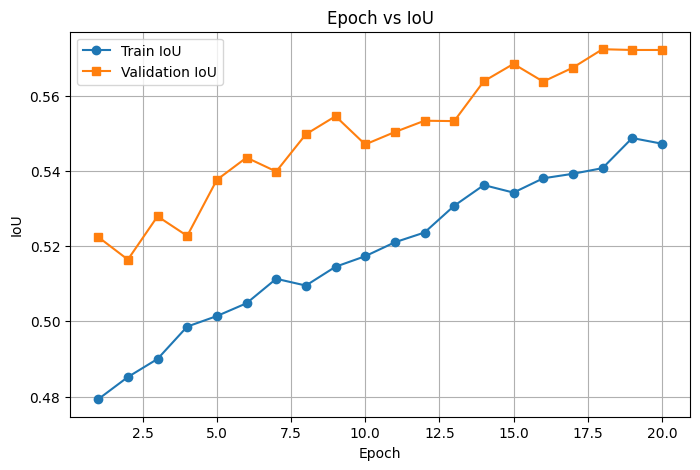

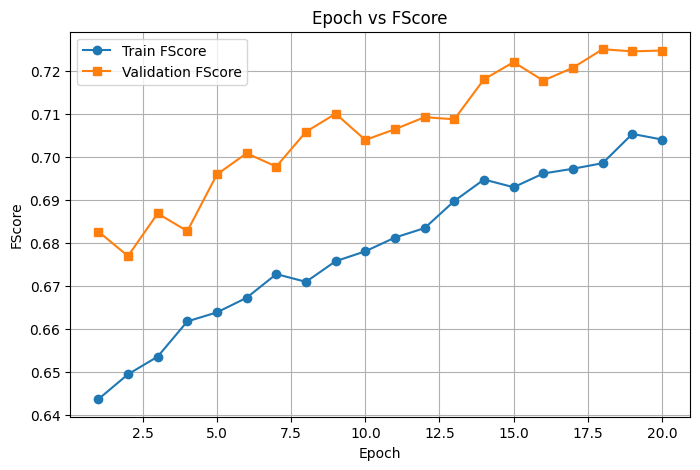

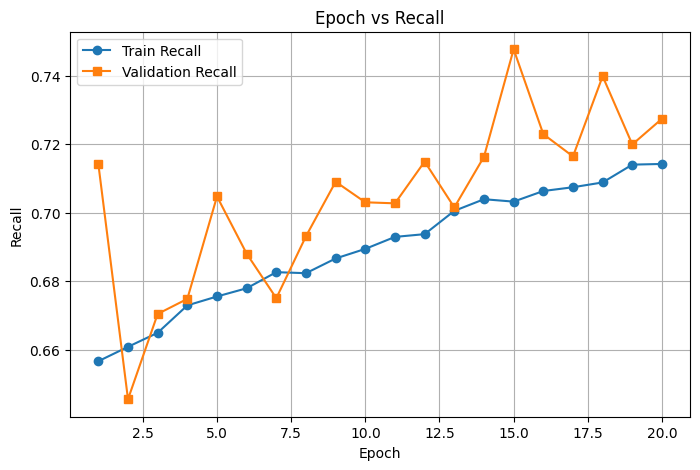

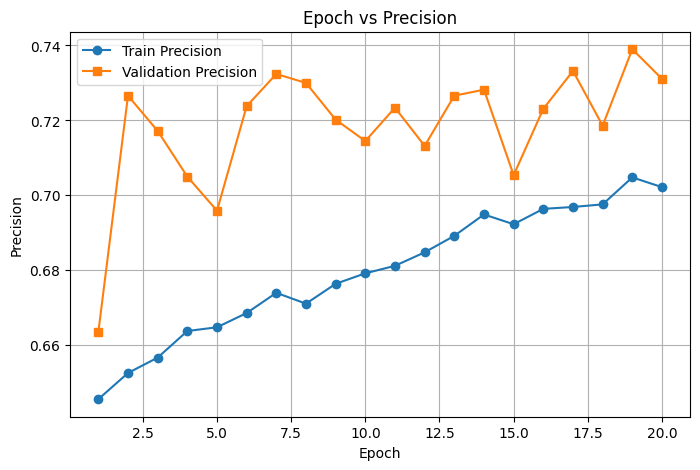

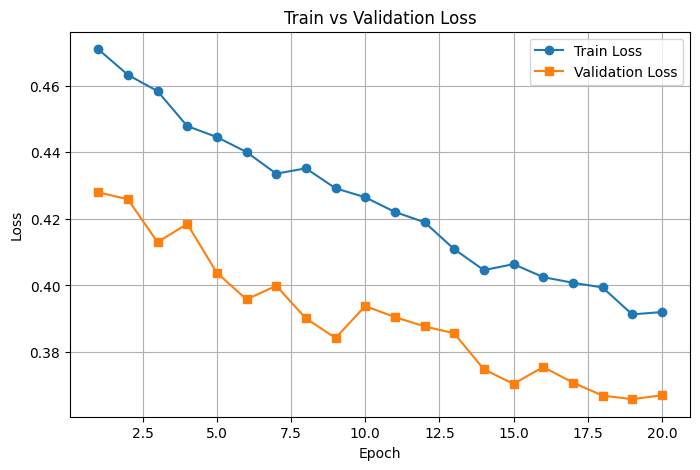

In [30]:
import matplotlib.pyplot as plt

# ------------------- EPOCHS -------------------
epochs = list(range(1, 21))

# ------------------- IoU -------------------
train_iou = [
    0.4793, 0.4852, 0.4900, 0.4986, 0.5014,
    0.5048, 0.5113, 0.5095, 0.5145, 0.5173,
    0.5210, 0.5236, 0.5307, 0.5362, 0.5342,
    0.5380, 0.5392, 0.5407, 0.5487, 0.5472
]

val_iou = [
    0.5224, 0.5164, 0.5279, 0.5227, 0.5376,
    0.5435, 0.5398, 0.5497, 0.5545, 0.5470,
    0.5503, 0.5533, 0.5532, 0.5638, 0.5684,
    0.5637, 0.5674, 0.5723, 0.5721, 0.5721
]

# ------------------- FScore -------------------
train_f1 = [
    0.6436, 0.6494, 0.6535, 0.6617, 0.6638,
    0.6672, 0.6727, 0.6709, 0.6757, 0.6780,
    0.6812, 0.6834, 0.6897, 0.6947, 0.6929,
    0.6961, 0.6972, 0.6985, 0.7053, 0.7040
]

val_f1 = [
    0.6826, 0.6769, 0.6868, 0.6827, 0.6959,
    0.7008, 0.6977, 0.7058, 0.7100, 0.7039,
    0.7064, 0.7092, 0.7087, 0.7180, 0.7220,
    0.7177, 0.7207, 0.7250, 0.7245, 0.7247
]

# ------------------- Precision -------------------
train_precision = [
    0.6456, 0.6526, 0.6567, 0.6638, 0.6648,
    0.6686, 0.6740, 0.6711, 0.6764, 0.6792,
    0.6812, 0.6848, 0.6892, 0.6949, 0.6923,
    0.6964, 0.6969, 0.6976, 0.7048, 0.7022
]

val_precision = [
    0.6635, 0.7266, 0.7172, 0.7050, 0.6959,
    0.7238, 0.7324, 0.7300, 0.7202, 0.7145,
    0.7234, 0.7132, 0.7266, 0.7282, 0.7054,
    0.7231, 0.7332, 0.7186, 0.7390, 0.7311
]

# ------------------- Recall -------------------
train_recall = [
    0.6566, 0.6608, 0.6649, 0.6729, 0.6755,
    0.6779, 0.6826, 0.6823, 0.6866, 0.6894,
    0.6929, 0.6937, 0.7005, 0.7039, 0.7032,
    0.7063, 0.7074, 0.7088, 0.7140, 0.7142
]

val_recall = [
    0.7142, 0.6455, 0.6704, 0.6748, 0.7047,
    0.6880, 0.6750, 0.6931, 0.7090, 0.7030,
    0.7027, 0.7149, 0.7015, 0.7163, 0.7477,
    0.7229, 0.7164, 0.7398, 0.7199, 0.7274
]

# ------------------- Loss -------------------
train_loss = [
    0.471, 0.4633, 0.4584, 0.4479, 0.4446,
    0.4401, 0.4336, 0.4352, 0.4292, 0.4265,
    0.4221, 0.4190, 0.4109, 0.4046, 0.4064,
    0.4025, 0.4008, 0.3994, 0.3913, 0.3920
]

val_loss = [
    0.428, 0.4259, 0.4130, 0.4185, 0.4038,
    0.3958, 0.3999, 0.3901, 0.3842, 0.3938,
    0.3905, 0.3877, 0.3856, 0.3748, 0.3704,
    0.3755, 0.3708, 0.3669, 0.3658, 0.3670
]

# ============================================================
# ---------------------- PLOTS -----------------------------
# ============================================================

# IoU
plt.figure(figsize=(8,5))
plt.plot(epochs, train_iou, 'o-', label='Train IoU')
plt.plot(epochs, val_iou, 's-', label='Validation IoU')
plt.xlabel('Epoch'); plt.ylabel('IoU')
plt.title('Epoch vs IoU')
plt.legend(); plt.grid(True)
plt.show()

# FScore
plt.figure(figsize=(8,5))
plt.plot(epochs, train_f1, 'o-', label='Train FScore')
plt.plot(epochs, val_f1, 's-', label='Validation FScore')
plt.xlabel('Epoch'); plt.ylabel('FScore')
plt.title('Epoch vs FScore')
plt.legend(); plt.grid(True)
plt.show()

# Recall
plt.figure(figsize=(8,5))
plt.plot(epochs, train_recall, 'o-', label='Train Recall')
plt.plot(epochs, val_recall, 's-', label='Validation Recall')
plt.xlabel('Epoch'); plt.ylabel('Recall')
plt.title('Epoch vs Recall')
plt.legend(); plt.grid(True)
plt.show()

# Precision
plt.figure(figsize=(8,5))
plt.plot(epochs, train_precision, 'o-', label='Train Precision')
plt.plot(epochs, val_precision, 's-', label='Validation Precision')
plt.xlabel('Epoch'); plt.ylabel('Precision')
plt.title('Epoch vs Precision')
plt.legend(); plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, 'o-', label='Train Loss')
plt.plot(epochs, val_loss, 's-', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend(); plt.grid(True)
plt.show()

